In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def relu(z):
    return np.maximum(0, z)


def relu_derivative(z):
    return (z > 0).astype(float)


def binary_cross_entropy(y_true, y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [3]:
def load_data_augmented(positive_class=0, data_dir='./data', target_pos=9000):
    base_transform = T.ToTensor()
    aug_transform = T.Compose([
        T.RandomHorizontalFlip(),
        T.RandomRotation(20),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        T.ToTensor()
    ])

    train_set = CIFAR10(root=data_dir, train=True, download=True)
    x_train = train_set.data.astype(np.float32) / 255.0
    y_train = np.array(train_set.targets).flatten()

    pos_idx = np.where(y_train == positive_class)[0]
    neg_idx = np.where(y_train != positive_class)[0]
    X_pos = x_train[pos_idx]
    X_neg = x_train[neg_idx]

    augmented = []
    np.random.seed(42)
    while len(augmented) + len(X_pos) < target_pos:
        i = np.random.randint(len(X_pos))
        pil = T.ToPILImage()(X_pos[i])
        img_aug = aug_transform(pil).permute(1, 2, 0).numpy()
        augmented.append(img_aug)

    X_pos_aug = np.vstack([X_pos, np.array(augmented)])
    y_pos_aug = np.ones(len(X_pos_aug), dtype=int)

    idx_neg = np.random.choice(len(X_neg), size=target_pos, replace=False)
    X_neg_samp = X_neg[idx_neg]
    y_neg_samp = np.zeros(target_pos, dtype=int)

    X_comb = np.vstack([X_pos_aug, X_neg_samp])
    y_comb = np.hstack([y_pos_aug, y_neg_samp])
    perm = np.random.permutation(len(y_comb))
    X_shuf = X_comb[perm]
    y_shuf = y_comb[perm]

    X_flat = X_shuf.reshape(X_shuf.shape[0], -1)
    y_shuf = y_shuf.reshape(-1, 1)
    return X_flat, y_shuf

In [4]:
class NeuralNetwork:
    def __init__(self, layer_dims, activations, optimizer_cfg):
        self.L = len(layer_dims) - 1
        self.layer_dims = layer_dims
        self.activations = activations
        self.opt_cfg = optimizer_cfg
        self.params = self._init_params()
        self.vel = {f"W{i}": np.zeros_like(self.params[f"W{i}"]) for i in range(1, self.L + 1)}
        self.vel.update({f"b{i}": np.zeros_like(self.params[f"b{i}"]) for i in range(1, self.L + 1)})
        self.history = {'train_loss': [], 'train_acc': []}

    def _init_params(self):
        np.random.seed(42)
        P = {}
        for i in range(1, self.L + 1):
            din, dout = self.layer_dims[i - 1], self.layer_dims[i]
            act = self.activations[i - 1]
            if act == 'relu':
                P[f"W{i}"] = np.random.randn(dout, din) * np.sqrt(2 / din)
            else:
                P[f"W{i}"] = np.random.randn(dout, din) * np.sqrt(1 / din)
            P[f"b{i}"] = np.zeros((dout, 1))
        return P

    def _activation(self, Z, f):
        return relu(Z) if f == 'relu' else sigmoid(Z)

    def _act_deriv(self, Z, f):
        return relu_derivative(Z) if f == 'relu' else sigmoid(Z) * (1 - sigmoid(Z))

    def forward(self, X):
        A = X.T
        caches = []
        for i in range(1, self.L + 1):
            W, b = self.params[f"W{i}"], self.params[f"b{i}"]
            Z = W @ A + b
            A = self._activation(Z, self.activations[i - 1])
            caches.append((A, Z))
        return A, caches

    def compute_loss(self, Y_hat, Y):
        return binary_cross_entropy(Y.flatten(), Y_hat.flatten())

    def backward(self, X, Y, caches):
        m = X.shape[0]
        grads = {}
        A_last, _ = caches[-1]
        dZ = A_last - Y.T
        for i in reversed(range(1, self.L + 1)):
            A_prev = caches[i - 2][0] if i > 1 else X.T
            grads[f"dW{i}"] = (1 / m) * dZ @ A_prev.T
            grads[f"db{i}"] = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
            if i > 1:
                W = self.params[f"W{i}"]
                dA_prev = W.T @ dZ
                Z_prev = caches[i - 2][1]
                dZ = dA_prev * self._act_deriv(Z_prev, self.activations[i - 2])
        return grads

    def update(self, grads):
        lr = self.opt_cfg['lr']
        beta = self.opt_cfg.get('momentum', 0)
        for i in range(1, self.L + 1):
            self.vel[f"W{i}"] = beta * self.vel[f"W{i}"] + (1 - beta) * grads[f"dW{i}"]
            self.vel[f"b{i}"] = beta * self.vel[f"b{i}"] + (1 - beta) * grads[f"db{i}"]
            self.params[f"W{i}"] -= lr * self.vel[f"W{i}"]
            self.params[f"b{i}"] -= lr * self.vel[f"b{i}"]

    def train(self, X, Y, epochs=50, print_freq=10):
        for ep in range(1, epochs + 1):
            Y_hat, cache = self.forward(X)
            loss = self.compute_loss(Y_hat, Y)
            preds = (Y_hat.T >= 0.5).astype(int)
            acc = np.mean(preds == Y)
            grads = self.backward(X, Y, cache)
            self.update(grads)
            self.history['train_loss'].append(loss)
            self.history['train_acc'].append(acc)
            if ep % print_freq == 0:
                print(f"Epoch {ep}: loss={loss:.4f}, acc={acc:.4f}")

    def predict(self, X):
        Y_hat, _ = self.forward(X)
        return (Y_hat.T >= 0.5).astype(int)

100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [02:22<00:00, 1.20MB/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified

== Training GD-Sigmoid ==
Epoch 25: loss=0.5981, acc=0.7692
Epoch 50: loss=0.5387, acc=0.7799

== Training Momentum-ReLU ==
Epoch 25: loss=0.4817, acc=0.7738
Epoch 50: loss=0.4593, acc=0.7848


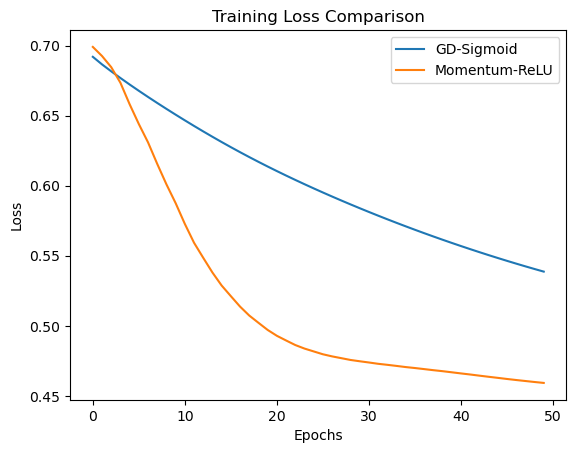

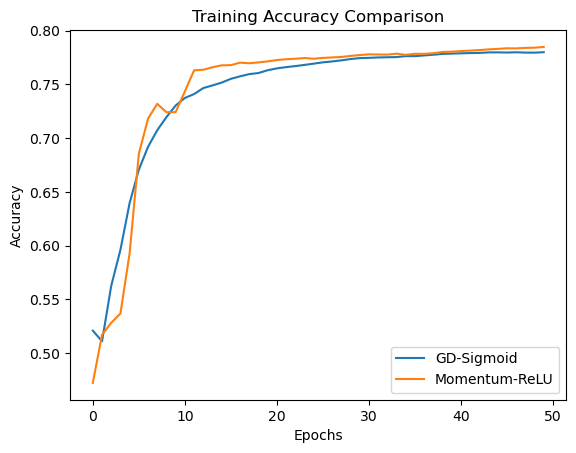


-- Test Set Evaluation --

GD-Sigmoid:
[[6962 2038]
 [ 296  704]]
              precision    recall  f1-score   support

           0     0.9592    0.7736    0.8564      9000
           1     0.2567    0.7040    0.3763      1000

    accuracy                         0.7666     10000
   macro avg     0.6080    0.7388    0.6164     10000
weighted avg     0.8890    0.7666    0.8084     10000


Momentum-ReLU:
[[7114 1886]
 [ 346  654]]
              precision    recall  f1-score   support

           0     0.9536    0.7904    0.8644      9000
           1     0.2575    0.6540    0.3695      1000

    accuracy                         0.7768     10000
   macro avg     0.6055    0.7222    0.6169     10000
weighted avg     0.8840    0.7768    0.8149     10000



In [5]:
if __name__ == '__main__':
    X_train, y_train = load_data_augmented(positive_class=0, data_dir='./data', target_pos=9000)

    transform = T.ToTensor()
    test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
    X_test = test_set.data.astype(np.float32) / 255.0
    y_test = (np.array(test_set.targets).flatten() == 0).astype(int).reshape(-1, 1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    configs = [
        {'name': 'GD-Sigmoid', 'activations': ['sigmoid', 'sigmoid'], 'opt': {'lr': 0.1}},
        {'name': 'Momentum-ReLU', 'activations': ['relu', 'sigmoid'], 'opt': {'lr': 0.1, 'momentum': 0.9}}
    ]

    trained_models = {}
    results = {}
    for cfg in configs:
        print(f"\n== Training {cfg['name']} ==")
        nn = NeuralNetwork(
            layer_dims=[X_train.shape[1], 64, 1],
            activations=cfg['activations'],
            optimizer_cfg=cfg['opt']
        )
        nn.train(X_train, y_train, epochs=50, print_freq=25)
        trained_models[cfg['name']] = nn
        results[cfg['name']] = nn.history

    plt.figure()
    for name, h in results.items():
        plt.plot(h['train_loss'], label=name)
    plt.title('Training Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    for name, h in results.items():
        plt.plot(h['train_acc'], label=name)
    plt.title('Training Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print("\n-- Test Set Evaluation --")
    for name, nn in trained_models.items():
        print(f"\n{name}:")
        yp = nn.predict(X_test)
        print(confusion_matrix(y_test, yp))
        print(classification_report(y_test, yp, digits=4))